# Recommendation Systems Practice Project: Book Recommendation

---------------
## **Context**
---------------

Over 3.5 billion people use the internet for a variety of reasons. Online retail sales are expected to grow steadily in the coming years. One of the most important requirements of E-commerce portals is a book recommendation for ease of reading and referencing. A book recommendation system is a type of recommendation system in which the reader is recommended similar books based on his or her interests.

Book Recommendation Systems are used by the vast majority of E-commerce businesses such as Amazon, Barnes and Noble, Flipkart, Goodreads, and other online retailers to recommend books that customers may be tempted to buy based on their preferences. This feature can assist in increasing shopping value while reducing shopping time. Logical recommendations not only assist customers in making purchases but also increase total sales value.

-----------------
## **Objective**
-----------------

In this case study, we will build three types of recommendation systems:
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**


-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes:
- user-Id: Unique ID for each user
- ISBN: International Standard Book Number. Books are identified by their respective ISBN
- Book-rating: Rating for each book expressed on a scale from 0-10

We will also use the **books** dataset to obtain book titles and other information. It contains the following attributes:
- ISBN: International Standard Book Number
- Book-title: Title of the book
- Book-author: Name of the author
- Year-of-Publication: Publication Year
- Publisher: Name of the publisher of the book
- Image-Url-S: Small image of the book (Amazon link)
- Image-Url-M: Medium size image of the book (Amazon link)
- Image-Url-L: Large size image of the book (Amazon link)

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [17]:
!pip uninstall numpy -y

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5


In [18]:
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)


**Note:** A pop-up will appear prompting you to restart the session. Please click on it, and then begin running the notebook from the cell below — not from the beginning.

In [19]:
# Mount your drive
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
# Installing surprise library
!pip install surprise

In [21]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

## **Loading the data**

In [22]:
# Reading the datasets
book = pd.read_csv("Books.csv")
rating = pd.read_csv("Ratings.csv")
user = pd.read_csv("Users.csv")

## **Exploring the ratings data**

In [23]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [24]:
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


**Let's merge the 'rating' and 'book' datasets and then we can choose only the columns relevant to our task.**

In [25]:
df = pd.merge(rating, book.drop_duplicates(['ISBN']), on="ISBN", how="left")
df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis =1, inplace = True)

# Rename the column names of the dataframe
df.rename(columns = {'User-ID':'user_id', 'ISBN':'book_id', "Book-Rating":"rating"}, inplace = True)
df.head()

,user_id,book_id,rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press


In [26]:
# Checking the info of the data
print("Dataset Summary:")
df.info()
# Missing values
print("\nMissing Values in each column:")
df.isnull().sum()

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   user_id              1149780 non-null  int64 
 1   book_id              1149780 non-null  object
 2   rating               1149780 non-null  int64 
 3   Book-Title           1031136 non-null  object
 4   Book-Author          1031134 non-null  object
 5   Year-Of-Publication  1031136 non-null  object
 6   Publisher            1031134 non-null  object
dtypes: int64(2), object(5)
memory usage: 61.4+ MB

Missing Values in each column:


user_id                     0
book_id                     0
rating                      0
Book-Title             118644
Book-Author            118646
Year-Of-Publication    118644
Publisher              118646
dtype: int64

**Observations:**
- There are 1149780 Rows and 7 Columns in the dataset.


In [27]:
# Many book_id contains combination of letters & digits. So we will convert the column to type 'string'
df['book_id']= df['book_id'].astype(str)

### **Checking the distribution of ratings**

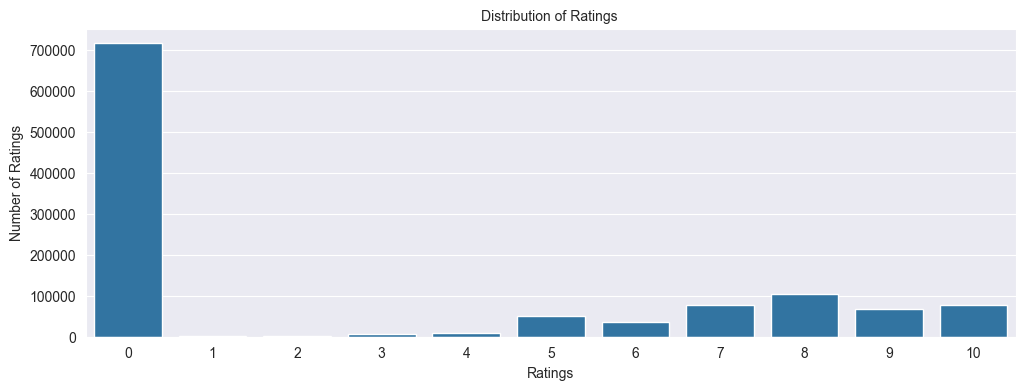

In [28]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x = 'rating', data = df)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**
- The ratings are given on a scale of 0-10.
- There are a significant number of ratings with value 0.
- The ratings seem to be right skewed as most of the ratings are concentrated towards the higher side of the scale.
- Majority of the ratings are between 6-10.
- There are very few ratings between 1-4.
- There are no ratings with value 1.
- The most common rating is 8.
- The least common rating is 1.

### **Dropping rows with rating equal to 0**

In [29]:
df.drop(df.index[df['rating'] == 0], inplace = True)

In [30]:
# Checking info of the data after removing entries with rating = 0
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              433671 non-null  int64 
 1   book_id              433671 non-null  object
 2   rating               433671 non-null  int64 
 3   Book-Title           383842 non-null  object
 4   Book-Author          383840 non-null  object
 5   Year-Of-Publication  383842 non-null  object
 6   Publisher            383840 non-null  object
dtypes: int64(2), object(5)
memory usage: 26.5+ MB


**Observations:**
- After removing the rows with rating 0, we have 1149779 rows and 7 columns in the dataset.
- There are no missing values in the dataset.

Let's check the distribution of ratings again.

### **Checking updated distribution of ratings**

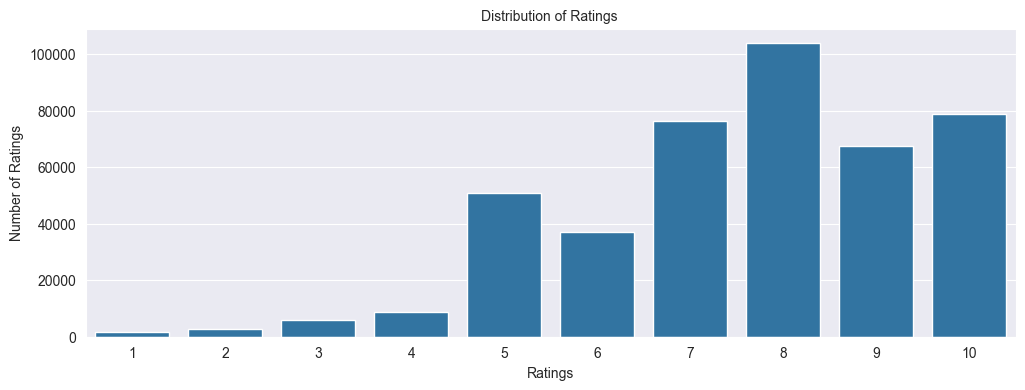

In [31]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x = 'rating', data = df)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**
- After removing the rows with rating 0, the distribution of ratings remains right skewed.
- The most common rating is still 8.
- The least common rating is still 1.
- The ratings are still concentrated towards the higher side of the scale.
- Majority of the ratings are still between 6-10.
- There are still very few ratings between 1-4.
- There are still no ratings with value 1.

In [34]:
# Finding the number of unique users
print(f"Number of unique users: {df['user_id'].nunique()}")

Number of unique users: 77805


In [35]:
# Finding the number of unique books
print(f"Number of unique books: {df['book_id'].nunique()}")

Number of unique books: 185973


**Observations:**
- There are 77805 unique users in the dataset.
- There are 185973 unique books in the dataset.

In [36]:
df.groupby(['user_id', 'book_id']).count()

rating  Book-Title  Book-Author  Year-Of-Publication  \
user_id book_id                                                            
8       0002005018       1           1            1                    1   
        074322678X       1           1            1                    1   
        0887841740       1           1            1                    1   
        1552041778       1           1            1                    1   
        1567407781       1           1            1                    1   
...                    ...         ...          ...                  ...   
278854  0375703063       1           1            1                    1   
        042516098X       1           1            1                    1   
        0425163393       1           1            1                    1   
        0553275739       1           1            1                    1   
        0553579606       1           1            1                    1   

                    Publisher  
user_id book_id                
8       0002005018          1  
        074322678X          1  
        0887841740          1  
        1552041778          1  
        1567407781          1  
...                       ...  
278854  0375703063          1  
        042516098X          1  
        0425163393          1  
        0553275739          1  
        0553579606          1  

[433671 rows x 5 columns]

In [37]:
df.groupby(['user_id', 'book_id']).count()['rating'].sum()

433671

**Observation:**
- The **sum is equal to the total number of observations**, which implies that **there is only one interaction between a book and a user**.

#### Which book has the highest number of reviews / ratings in the dataset?

In [38]:
# Finding the most rated books in the dataset
df['book_id'].value_counts().head(10)

book_id
0316666343    707
0971880107    581
0385504209    487
0312195516    383
0679781587    333
0060928336    320
059035342X    313
0142001740    307
0446672211    295
044023722X    281
Name: count, dtype: int64

**Observations:**
- The book with book_id '0316666343' has the highest number of reviews/ratings in the dataset, with 707 ratings.
- The second most rated book has book_id '0971880107' with 581 ratings.
- The third most rated book has book_id '0385504209' with 487 ratings.

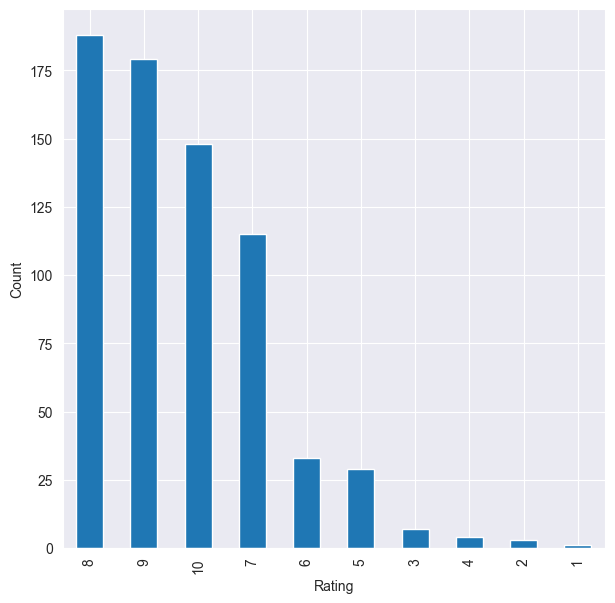

In [39]:
# Plotting distributions of ratings for the most interacted book

plt.figure(figsize=(7,7))

df[df['book_id'] == '0316666343']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

**Observations:**
- The most common rating for the book with book_id '0316666343' is 8.
- The ratings for this book are also right skewed, with most ratings concentrated towards the higher side of the scale.
- Majority of the ratings for this book are between 6-10.
- There are very few ratings between 1-4 for this book.

In [40]:
# Finding the user who interacted most
df['user_id'].value_counts().head(10)

user_id
11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
76499     1036
171118    1035
235105    1023
16795      968
248718     948
Name: count, dtype: int64

**Observations:**
- The user with user_id 11676 has the highest number of interactions in the dataset, with 8524 ratings.
- The second most active user has user_id 98391 with 5802 ratings.
- The third most active user has user_id 153662 with 1969 ratings.

## **Data Preparation**

As this dataset is still quite large and has 433671 observations, it is not be computationally efficient to build a model using this. Moreover, there are many users who have only rated a few books and also there are also books which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.

Here, We will be taking users who have given at least 50 rating, as we prefer to have some number of rating of a book and the book which has at least 10 rating, as when we shop online we prefer to have some number of rating of that product.

In [41]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to find their number of books
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [42]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [43]:
df.shape

(175023, 7)

In [44]:
# Get the column containing the books
books = df.book_id
# Create a dictionary from books to find their number of users
ratings_count = dict()
for book in books:
    # If we already have the book, just add 1 to their rating count
    if book in ratings_count:
    	ratings_count[book] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[book] = 1

In [45]:
# We want our book to be interacted by at least 10 users to be considered
RATINGS_CUTOFF = 10
remove_books = []
for book, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_books.append(book)
df= df.loc[~df.book_id.isin(remove_books)]

In [46]:
df.shape

(26698, 7)

### **Distribution of the user-books interactions in the dataset**

In [47]:
df.nunique()

user_id                1257
book_id                1497
rating                   10
Book-Title             1367
Book-Author             587
Year-Of-Publication      43
Publisher               204
dtype: int64

In [48]:
# Finding user-books interactions distribution
count_interactions = df.groupby('user_id').size()
count_interactions

user_id
254       18
638       20
643        3
1025       7
1211       3
          ..
277427    36
278026    11
278137     8
278188     9
278418     9
Length: 1257, dtype: int64

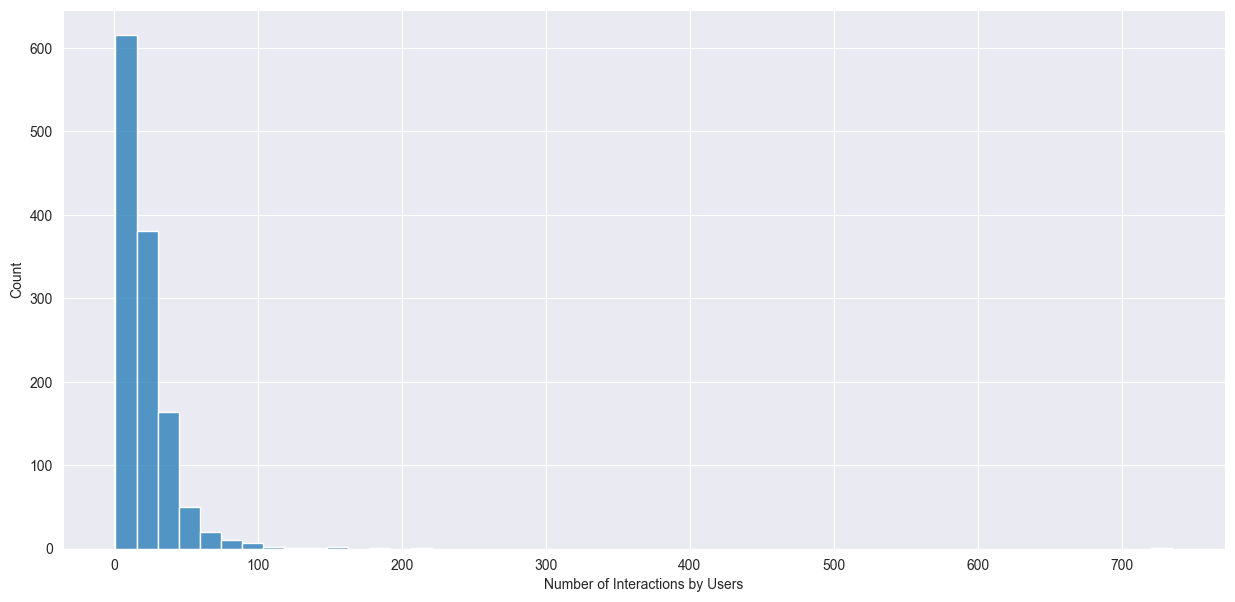

In [49]:
# Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions, bins=50, kde=False)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations:**

**As we have now explored the data, let's start building Recommendation Systems**

## **Model 1: Create Rank-Based Recommendation System**

- Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend book to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend book to the new user.

- To build the rank-based recommendation system, we take average of all the ratings provided to each book and then rank them based on their average rating.

In [ ]:
# Calculating average ratings for each book_id
average_rating = ________________________

# Calculating the count of ratings for each book_id
count_rating = __________________________

# Making a dataframe with the count and average of ratings
final_rating = __________________________

In [ ]:
final_rating.head()

In [ ]:
final_rating['rating_count'].value_counts()

Now, let's create a function to find the **top n books** for a recommendation based on the average ratings of books. We can also add a **threshold for a minimum number of interactions** for a book to be considered for recommendation.

In [ ]:
def top_n_books(data, n, min_interaction=100):

    # Finding books with minimum number of interactions
    recommendations = ___________________________________

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(________________)

    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get books to recommend.

##### **Recommending top 5 Book with 10 minimum interactions based on popularity**

In [ ]:
res = list(top_n_books(final_rating, 5, 10))
# Name of the books
list_of_books = []
for i in res:
    list_of_books.append(df[df['book_id']== str(i) ]['Book-Title'].unique()[0])
list_of_books

##### Recommending top 5 Book with 100 minimum interactions based on popularity

In [ ]:
res2 = list(top_n_books(________________))
# Name of the books
list_of_book = []
for i in res2:
    list_of_book.append(____________________)
list_of_book

## **Model 2: Collaborative Filtering Based Recommendation System**

In this type of recommendation system, we do not need any information about the users or items. We only need user-item interaction data to build a collaborative recommendation system. For example:
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on Goodreads, movie ratings on IMDB, etc.</li>
    <li><b>Likes</b> of users on different Facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### **Types of Collaborative Filtering**

- Similarity/Neighborhood based
- Model based

Below we are building a similarity-based recommendation system using cosine similarity and using KNN to find similar users who are the nearest neighbor to the given user.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in the structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

**Before building the recommendation systems, let's  go over some some basic terminologies we are going to use:**

**Relevant item** - An item (book in this case) that is actually **rated higher than the threshold rating (here 7)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 7) is a recommended item**, if the **predicted rating is below the threshold then that book will not be recommended to the user**.  


**False Negative (FN)** - It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider** which they would like to minimize.

**False Positive (FP)** - It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider** which they would also like to minimize.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant books, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are the two most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k and Recall@ k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- The following function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [ ]:
def precision_recall_at_k(model, k=10, threshold=7):

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions is calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    # Mean of all the predicted recalls is calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) # Command to print the overall precision
    print('Recall: ', recall) # Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

**Let's encode the user_id and book_id for simplicity, also encoding them will not make any change in the prediction.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
data=df[['user_id','book_id']].apply(LabelEncoder().___________) # Hint: Use fit_transform
data['rating']=df['rating']
data.head()

In [ ]:
# Creating a copy of the above dataset for further use
df_rating = data.copy()

In [ ]:
# Calculating average ratings
average_rating = ____________________

# Calculating the count of ratings
count_rating = ______________________

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = ______________________
final_rating.head()

Below we are loading the `data` dataset, which is a pandas dataframe, into a different format called `surprise.dataset.DatasetAutoFolds` which is required by this library. To do this, we will be using the classes `Reader` and `Dataset`

**Making the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(data[['user_id', 'book_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are ready to build the first baseline similarity based recommendation system using cosine similarity and KNN.

### **User-Based Collaborative Filtering Recommendation System**

In [ ]:
sim_options = {'name': ________,
               'user_based': ______}

algo_knn_user = KNNBasic(_______________)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user._______________

# Let us compute precision@k, recall@k, and f_1 score with k =10. Hint: use precision_recall_at_k() function defined above
__________________

**Observations:______**

**What is the predicted rating for the user with userId=1326 and for book_id=12126?**

In [ ]:
algo_knn_user.predict(_____,______, r_ui=8, verbose=True)

**Observations:______**

Let's predict the rating for the same `userId=1326` but for a book which this user has not a rated before, i.e., `book_id=2150`

In [ ]:
algo_knn_user.predict(______,______, verbose=True)

### **Improving similarity based recommendation system by tuning its hyperparameters**

Below we will be tuning hyperparameters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm -

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

**Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system.**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(________)

# Best RMSE score
print(gs.best_score[_____])

# Combination of parameters that gave the best RMSE score
print(gs.best_params[_____])

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-based collaborative filtering
sim_options = __________________

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = __________________

# Training the algorithm on the train set
similarity_algo_optimized.____________________

# Let us compute precision@k and recall@k with k=10.
______________

**Observations:______**

**What is the predicted rating for the user with user_id=1326 and for book_id=12344 using the tuned user-based collaborative filtering?**

In [ ]:
similarity_algo_optimized.predict(_____,______, r_ui=8, verbose=True)

**Observations:______**

Below we are predicting rating for the same `user_id=1326` but for a book which this user has not a rated before, i.e., `book_id=2150`.

In [ ]:
similarity_algo_optimized.predict(_____,______, verbose=True)

**Identifying users similar to a given user (nearest neighbors)**

We can find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `user_id=1`.

In [ ]:
similarity_algo_optimized.get_neighbors(1, k=______)

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: a rating dataset
- user_id:  user_id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended book ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='book_id', values='rating')

    # Extracting those book ids which the user_id has not interacted with yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the book id which user_id has not interacted with yet
    for book_id in non_interacted_items:

        # Predicting the ratings for those non interacted book ids by this user
        est = algo.predict(user_id, book_id).est

        # Appending the predicted ratings
        recommendations.append((book_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returning top n predicted rating items for this user

In [ ]:
df_rating=df_rating.drop_duplicates()

**Predicting the top 5 items for userId=1 using the similarity-based recommendation system**

In [ ]:
# Hint: use the above get_recommendations function and use similarity_algo_optimized as the algo
recommendations = ____________________________

In [ ]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['book_Id', 'predicted_ratings'])

### **Correcting the Ratings and Ranking the above books**

While comparing the ratings of two books, it is not only the **ratings** that describe the **likelihood of the user to that book**. Along with the rating the **number of users who have read that book** also becomes a important point to consider. Due to this, we have calculated the **"corrected_ratings"** for each book. Commonly higher the **"rating_count" of a book more reliable the rating is**. To interpret the above concept, a **book rated 8 with rating_count 5 is less liked in comparison to a book rated 7 with a rating count of 50**. It has been **empirically found that the likelihood of the book is directly proportional to the inverse of the square root of the rating_count of the book**.

In [ ]:
def ranking_books(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_books = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_books = ranked_books.merge(pd.DataFrame(recommendations, columns=['book_id', 'predicted_ratings']), on='book_id', how='inner')

  # Rank the books based on corrected ratings
  ranked_books['corrected_ratings'] = ranked_books['predicted_ratings'] - 1 / np.sqrt(ranked_books['rating_count'])

  # Sort the books based on corrected ratings
  ranked_books = ranked_books.sort_values('corrected_ratings', ascending=False)

  return ranked_books

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some books with ratings 10 and **we can't have a rating more than 10 for a book**.

In [ ]:
# Applying the ranking_books function and sorting it based on corrected ratings
ranking_books(recommendations, final_rating)

### **Model 3: Item based Collaborative Filtering Recommendation System**

* We have seen **user-user similarity-based collaborative filtering**. Now, let us look into similarity-based collaborative filtering where similarity is calculated **between items**.

In [ ]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': _________}

# Defining nearest neighbour algorithm
algo_knn_item = ___________________

# Train the algorithm on the train set
algo_knn_item._____________________

# Let us compute precision@k, recall@k, and f_1 score with k=10
__________________

**Observations:______**

**What is the predicted  rating for an user with user_id=1326 and for book_id=12344?**

In [ ]:
# Predict rating for user_id=1326 and for book_id= 12344
_________________

In [ ]:
# Predict rating for user_id=1326 and for book_id= 2150
_________________

**Tuning the baseline item-based collaborative filtering recommendation system's hyperparameters and determining the RMSE for the tuned item-based collaborative filtering recommendation system**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [_______], 'min_k': [______],
              'sim_options': {'name': [_______],
                              'user_based':________}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(____________________)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score[______])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params[______])

Now, let's build the **final model** by using **optimal values of the hyperparameters** which we received by using grid search cross-validation.

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(_________________________)

# Training the algorithm on the train set
similarity_algo_optimized_item._________________

# Let us compute precision@k and recall@k with k=10
______________________

**Observations:______**

**Let's predict the rating for an user with user_id=1326 and for book_id= 12344.**

In [ ]:
# Predict rating for user_id=1326 and for book_id= 12344
_________________

In [ ]:
# Predict rating for user_id=1326 and for book_id= 2150
_________________

**Observations:______**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `BookId=1`.

In [ ]:
similarity_algo_optimized_item._______________

#### Predicted top 5 books for user_id=1 with similarity based recommendation system

In [ ]:
recommendations = _____________________________

In [ ]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(__________________________________)

In [ ]:
# Applying the ranking_books function and sorting it based on corrected ratings
________________________

## **Model 4: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**. The recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix** that we already learned earlier. But SVD does not work when we **miss values** in the **user-item matrix**.

#### **Building a baseline matrix factorization recommendation system**

In [ ]:
# Using SVD matrix factorization
svd = SVD(________)

# Training the algorithm on the train set
svd.___________

# Let us compute precision@k and recall@k with k=10
____________

**Observations:______**

**What is the predicted  rating for an user with user_id=1326 and for book_id= 12344?**

In [ ]:
# Making prediction for user_id 1326 and book_id 12344
____________

In [ ]:
# Making prediction for user_id 1326 and book_id 2150
____________

### **Improving matrix factorization based recommendation system by tuning its hyperparameters**

In SVD, rating is predicted as:

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [_________], 'lr_all': [_________],
              'reg_all': [__________]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(___________________)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

Now, let's **build the final model** by using **optimal values** of the hyperparameters which we received by using grid search cross-validation.

In [ ]:
# Building the optimized SVD modelh
svd_optimized = SVD(____________)

# Training the algorithm on the train set
svd_optimized=svd_optimized._____________

# Let us compute precision@k and recall@k with k=10
___________________

**Observations:______**

**Let's predict the rating for an user with user_id=1326 and for book_id=12344.**

In [ ]:
# Making prediction for user_id 1326 and book_id 12344
______________

In [ ]:
# Making prediction for user_id 1326 and book_id 2150
______________

**Now, let's recommend the books using the optimized svd model**

In [ ]:
# Getting top 5 recommendations for user_id 1 using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(________, 1, 5, _________)

In [ ]:
# Ranking book based on above recommendations. Hint: use ranking_books function
ranking_books(_______, _________)

## **Conclusions:____**